<a href="https://colab.research.google.com/github/Wongel-Yilma/PINN-SR/blob/main/PINN_SR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.io import loadmat
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

SEED = 1

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        torch.manual_seed(SEED)
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 20)
        self.fc6 = nn.Linear(20, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.tanh(self.fc5(x))
        x = self.fc6(x)

        return x

    def neural_net(self, x, t):
        x = x.clone().detach().requires_grad_(True)
        t = t.clone().detach().requires_grad_(True)

        input_xt = torch.cat([x, t], dim=1)
        c_output = self.forward(input_xt)

        c_t = torch.autograd.grad(c_output, t, grad_outputs=torch.ones_like(c_output),
                                  create_graph=True, retain_graph=True)[0]
        c_x = torch.autograd.grad(c_output, x, grad_outputs=torch.ones_like(c_output),
                                  create_graph=True, retain_graph=True)[0]
        c_xx = torch.autograd.grad(c_x, x, grad_outputs=torch.ones_like(c_x),
                                  create_graph=True, retain_graph=True)[0]
        c_xxx = torch.autograd.grad(c_xx, x, grad_outputs=torch.ones_like(c_xx),
                                    create_graph=True, retain_graph=True)[0]

        return c_output, c_t, c_x, c_xx, c_xxx








In [ ]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, X, c):
        self.X = X
        self.c = c

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.c[idx]

In [ ]:

def TrainSTRidge(R, Ut, lam, d_tol, maxit = 25, STR_iters = 10, l0_penalty = None, normalize = 2, split = 0.8, print_best_tol = False):
    """
    This function trains a predictor using STRidge.

    It runs over different values of tolerance and trains predictors on a training set, then evaluates them
    using a loss function on a holdout set.

    Please note published article has typo.  Loss function used here for model selection evaluates fidelity using 2-norm,
    not squared 2-norm.
    """

    # Split data into 80% training and 20% test, then search for the best tolderance.
    np.random.seed(0) # for consistancy
    n,_ = R.shape
    train = np.random.choice(n, int(n*split), replace = False)
    test = [i for i in np.arange(n) if i not in train]
    TrainR = R[train,:]
    TestR = R[test,:]
    TrainY = Ut[train,:]
    TestY = Ut[test,:]
    D = TrainR.shape[1]

    # Set up the initial tolerance and l0 penalty
    d_tol = float(d_tol)
    tol = d_tol
    if l0_penalty == None: l0_penalty = 0.001*np.linalg.cond(R)

    # Get the standard least squares estimator
    w = np.zeros((D,1))
    w_best = np.linalg.lstsq(TrainR, TrainY,rcond=None)[0]
    err_best = np.linalg.norm(TestY - TestR.dot(w_best), 2) + l0_penalty*np.count_nonzero(w_best)
    tol_best = 0

    # Now increase tolerance until test performance decreases
    for iter in range(maxit):

        # Get a set of coefficients and error
        w = STRidge(TrainR,TrainY,lam,STR_iters,tol,normalize = normalize)
        err = np.linalg.norm(TestY - TestR.dot(w), 2) + l0_penalty*np.count_nonzero(w)

        # Has the accuracy improved?
        if err <= err_best:
            err_best = err
            w_best = w
            tol_best = tol
            tol = tol + d_tol

        else:
            tol = max([0,tol - 2*d_tol])
            d_tol  = 2*d_tol / (maxit - iter)
            tol = tol + d_tol

    if print_best_tol: print("Optimal tolerance:", tol_best)

    return w_best


def STRidge(X0, y, lam, maxit, tol, normalize = 2, print_results = False):
    """
    Sequential Threshold Ridge Regression algorithm for finding (hopefully) sparse
    approximation to X^{-1}y.  The idea is that this may do better with correlated observables.

    This assumes y is only one column
    """

    n,d = X0.shape
    X = np.zeros((n,d), dtype=np.complex64)
    # First normalize data
    if normalize != 0:
        Mreg = np.zeros((d,1))
        for i in range(0,d):
            Mreg[i] = 1.0/(np.linalg.norm(X0[:,i],normalize))
            X[:,i] = Mreg[i]*X0[:,i]
    else: X = X0

    # Get the standard ridge esitmate
    if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y),rcond=None)[0]
    else: w = np.linalg.lstsq(X,y,rcond=None)[0]
    num_relevant = d
    biginds = np.where( abs(w) > tol)[0]

    # Threshold and continue
    for j in range(maxit):

        # Figure out which items to cut out
        smallinds = np.where( abs(w) < tol)[0]
        new_biginds = [i for i in range(d) if i not in smallinds]

        # If nothing changes then stop
        if num_relevant == len(new_biginds): break
        else: num_relevant = len(new_biginds)

        # Also make sure we didn't just lose all the coefficients
        if len(new_biginds) == 0:
            if j == 0:
                #if print_results: print "Tolerance too high - all coefficients set below tolerance"
                return w
            else: break
        biginds = new_biginds

        # Otherwise get a new guess
        w[smallinds] = 0
        if lam != 0: w[biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam*np.eye(len(biginds)),X[:, biginds].T.dot(y),rcond=None)[0]
        else: w[biginds] = np.linalg.lstsq(X[:, biginds],y,rcond=None)[0]

    # Now that we have the sparsity pattern, use standard least squares to get w
    if type(biginds)==np.ndarray:
        if biginds.size>0: w[biginds] = np.linalg.lstsq(X[:, biginds],y,rcond=None)[0]
    elif type(biginds)== list:
        if biginds!=[]: w[biginds] = np.linalg.lstsq(X[:, biginds],y,rcond=None)[0]


    if normalize != 0: return np.multiply(Mreg,w)
    else: return w

In [ ]:
from itertools import chain
class PINN_SR():
    def __init__(self, batch_size, num_terms, history = False):
        torch.manual_seed(SEED)
        self.history = history
        self.batch_size = batch_size
        self.num_terms = num_terms
        self.criterion = nn.MSELoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.coefficients = nn.Parameter(torch.randn(self.num_terms, requires_grad=True, device=self.device))
        self.mask = torch.ones(self.num_terms, device = self.device)
        self.library_terms = [
            '1', "c", 'c^2', 'c^3',
            'c_z', 'c  c_z', 'c^2 c_z', 'c^3  c_z',
            'c_{zz}', 'c  c_{zz}', 'c^2 c_{zz}', 'c^3 c_{zz}',
            'c_{zzz}', 'c c_{zzz}', 'c^2 c_{zzz}', 'c^3 c_{zzz}',
        ]
        if self.history:
            self.physics_loss_hist = []
            self.data_loss_hist = []
            self.epoch_num = []
            self.total_loss_hist = []
            self.coeff_list = [self.coefficients.detach().cpu().numpy() ]
    def fit(self, X, c,lr, epochs, alpha_multiplier = 1e-10,regularizer = 'l1',gamma_1=1e-10, gamma_0 = 1e-12 , tol =1):
        """X is the input data, c is the output data"""
        self.lr = lr
        self.epochs = epochs
        self.gamma_1 = gamma_1
        self.gamma_0 = gamma_0
        self.tol = tol
        self.X = torch.Tensor(X).float()
        self.c = torch.Tensor(c).float()
        self.shape = X.shape
        self.torch_module = PINN()
        self.torch_module.to(self.device)
        self.optimizer = torch.optim.Adam(chain(self.torch_module.parameters(), [self.coefficients]), lr=self.lr)
        # print(self.optimizer.param_groups)
        dataset = MyDataset(self.X, self.c)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        self.alpha_multiplier = alpha_multiplier

        if regularizer=='l1':
            for epoch in range(self.epochs):
                for i, data in enumerate(dataloader, 0):
                    self.optimizer.zero_grad()
                    self.train(data)
                    self.optimizer.step()
                print("Epoch: {}; physics-loss {}; Data Loss: {} Total loss {}".format(epoch+1,self.p_loss, self.data_loss,self.loss))
                coefs = self.coefficients.detach().cpu().numpy()
                equation = ''
                for i in range(self.num_terms):
                    if np.abs(coefs[i]):
                        equation+=" +{:.3f} ".format(coefs[i])+self.library_terms[i]
                print("c_t =  ", equation )
                if self.history: self.save_history(epoch, coefs)

        elif regularizer=='l0':
            for epoch in range(self.epochs):
                for i, data in enumerate(dataloader, 0):
                    self.optimizer.zero_grad()
                    self.train(data)
                    self.optimizer.step()
                print("Epoch: {}; physics-loss {}; Data Loss: {} Total loss {}".format(epoch+1,self.p_loss, self.data_loss,self.loss))
                coefs = self.coefficients.detach().cpu().numpy()
                equation = ''
                for i in range(self.num_terms):
                    if np.abs(coefs[i]):
                        equation+=" +{:.3f} ".format(coefs[i])+self.library_terms[i]
                print("c_t =  ", equation )
                # print("Alpha: ", self.alpha.item())
                if self.history: self.save_history(epoch, coefs)


            print('#####$$$$$$$$$$##########$$$$$$$$$$$$#########$$$$$$$$$$$##############$$$$$$')
            print('#####$$$$$$$$$$##########$$$$$$$$$$$$#########$$$$$$$$$$$##############$$$$$$')
            print('#####$$$$$$$$$$##########$$$$$$$$$$$$#########$$$$$$$$$$$##############$$$$$$')
            print('#####$$$$$$$$$$##########$$$$$$$$$$$$#########$$$$$$$$$$$##############$$$$$$')
            print('RUNNING PYSINDY')
            self.run_SINDy()

    #### For l1 regularization learning
    def train(self, batch):
        inputs, value = batch
        inputs, value = inputs.to(self.device), value.to(self.device)

        x = inputs[:, 0:1]
        t = inputs[:, 1:2]

        c_nn, c_t, c_x, c_xx, c_xxx = self.torch_module.neural_net(x, t)
        self.p_loss, self.alpha = self.physics_loss(c_nn, c_t, c_x, c_xx, c_xxx, self.coefficients)
        self.data_loss = self.criterion(c_nn, value)
        # self.loss = self.data_loss + self.alpha_multiplier*self.alpha*self.p_loss + self.gamma_1*self.coefficients.norm(p = 1)
        self.loss = self.data_loss + self.alpha_multiplier*self.p_loss + self.gamma_1*self.coefficients.norm(p = 1)

        self.loss.backward()

    def train_with_l0(self, batch):
        inputs, value = batch
        inputs, value = inputs.to(self.device), value.to(self.device)

        x = inputs[:, 0:1]
        t = inputs[:, 1:2]

        c_nn, c_t,c_x,c_xx, c_xxx = self.torch_module.neural_net(x, t)
        # self.p_loss, self.alpha = self.physics_loss_with_l0(c_nn,c_t, c_x, c_xx, c_xxx, self.coefficients)
        self.p_loss, _ = self.physics_loss(c_nn,c_t, c_x, c_xx, c_xxx, self.coefficients)

        self.data_loss = self.criterion(c_nn, value)
        self.loss = self.data_loss + self.alpha_multiplier*self.p_loss+ self.gamma_1*self.coefficients.norm(p = 1)
        self.loss.backward()

    def physics_loss(self, c, c_t, c_x, c_xx, c_xxx,coefficients):
        # Each term has shape (batch_size, 1)
        terms = [
            torch.ones_like(c), c, c**2, c**3,
            c_x, c * c_x, c**2 * c_x, c**3 * c_x,
            c_xx, c * c_xx, c**2 * c_xx, c**3 * c_xx,
            c_xxx, c * c_xxx, c**2 * c_xxx, c**3 * c_xxx,
        ]

        alpha = torch.std(c)/torch.std(c_t)

        PHI = torch.cat(terms, dim=1)

        coeffs = coefficients.unsqueeze(1)

        f_pred = PHI @ coeffs

        p_loss =( torch.mean((f_pred - c_t) ** 2))**(0.5)
        return p_loss, alpha

    #########################################################################
    ############ Methods to run l0 regularized PINN  ########################
    #########################################################################

    def run_SINDy(self):
        print("Running SINDy with:", self.X.shape )

        x_eval, t_eval = self.X[:,0:1].to(self.device), self.X[:,1:2].to(self.device)
        c, c_t,c_x,c_xx, c_xxx = self.torch_module.neural_net(x_eval, t_eval)
        terms = [
            torch.ones_like(c), c, c**2, c**3,
            c_x, c * c_x, c**2 * c_x, c**3 * c_x,
            c_xx, c * c_xx, c**2 * c_xx, c**3 * c_xx,
            c_xxx, c * c_xxx, c**2 * c_xxx, c**3 * c_xxx,
        ]
        PHI = torch.cat(terms, dim=1)
        print("PHI shapes:", PHI.shape)

        PHI = PHI.detach().cpu().numpy()
        Y = c_t.detach().cpu().numpy()

        description = self.library_terms

        print("Running STRidge regression")
        print(PHI.shape)
        print(Y.shape)
        w = TrainSTRidge(PHI.real,Y, self.gamma_0, self.tol )[:,0].real
        equation = ''
        for i in range(self.num_terms):
            if np.abs(w[i])>0: equation+=" +{:.3f} ".format(w[i])+self.library_terms[i]
        print("c_t =  ", equation )
        print("W: ", w)
        new_mask = np.where(w==0,0,1)
        print("Mask: ", new_mask)
        ## Update Mask
        self.mask = torch.Tensor(new_mask).to(self.device)
        return self.mask




    def physics_loss_with_l0(self, c, c_t, c_x, c_xx, c_xxx,coefficients):
        # Each term has shape (batch_size, 1)
        terms = [
            torch.ones_like(c), c, c**2, c**3,
            c_x, c * c_x, c**2 * c_x, c**3 * c_x,
            c_xx, c * c_xx, c**2 * c_xx, c**3 * c_xx,
            c_xxx, c * c_xxx, c**2 * c_xxx, c**3 * c_xxx,
        ]

        alpha = torch.std(c)/torch.std(c_t)
        ## Applying the mask
        PHI = torch.cat(terms, dim=1)[:,mask]

        coeffs = coefficients.unsqueeze(1)[mask]

        f_pred = PHI @ coeffs

        p_loss =( torch.mean((f_pred - c_t) ** 2))**(0.5)
        return p_loss, alpha


    def predict(self, X):
        self.torch_module.eval()
        X = torch.Tensor(X).float()
        X = X.to(self.device)
        with torch.no_grad():
            outputs = self.torch_module(X)
        return outputs.cpu().numpy()

    def save_model(self, PATH):
        torch.save(self.torch_module, PATH)
        coeffs_to_save = self.coefficients.detach().cpu().numpy()
        np.save('coefficients',coeffs_to_save)
    def load_model(self, PATH):
        self.torch_module = torch.load(PATH, weights_only=False)
        coefficients_loaded = torch.from_numpy(np.load('./coefficients.npy'))
        self.coefficients = coefficients_loaded.to(self.device)
    def plot_losses(self ):
        colors = ['crimson', 'cornflowerblue', 'rosybrown']
        fig, ax = plt.subplots(1,1)
        plt.yscale('log')
        plt.plot(np.array(self.epoch_num), np.array(self.data_loss_hist), color = colors[0],label = r"$\mathcal{L}_{data}$")
        plt.plot(np.array(self.epoch_num), np.array(self.physics_loss_hist),color = colors[1], label = r"$\mathcal{L}_{physics}$")
        plt.plot(np.array(self.epoch_num), np.array(self.total_loss_hist), color = colors[2],label = r"$\mathcal{L}_{total}$")
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()
    def print_equations(coefs):
        for i in range(self.num_terms):
            if np.abs(coefs[i]):
                equation+=" +{:.3f} ".format(coefs[i])+self.library_terms[i]
        print("c_t =  ", equation )
    def save_history(self, epoch, coefs):
        self.epoch_num.append(epoch+1)
        self.data_loss_hist.append(self.data_loss.item())
        self.total_loss_hist.append(self.loss.item())
        self.physics_loss_hist.append(self.p_loss.item())
        self.coeff_list.append(coefs)

    def plot_coefficient_history(self):
        coeffs = np.array(self.coeff_list)
        fig, ax = plt.subplots(1,1)
        t= np.array([0,*np.array(self.epoch_num)])
        # plt.yscale('log')
        for i in range(self.num_terms):
            plt.plot(t, coeffs[:,i],label = r"${}$".format(self.library_terms[i]))
        plt.legend()
        plt.legend(bbox_to_anchor=(1.05, 1), loc='lower right', ncols = 3, fontsize = 12)
        plt.xlabel('Epochs')
        plt.ylabel('Coefficients')
        plt.show()






In [ ]:
np.random.seed(SEED)

data = loadmat('./MC_deposit.mat')['C'][:,:500]
nx, nt = data.shape
x = np.linspace(0,nx-1, nx)
t = np.linspace(0,nt-1, nt)
X, T = np.meshgrid(x, t,indexing='ij')
## Normalizing the input
X = X.reshape(-1,1)/(nx-1)
T = T.reshape(-1,1)/(nt-1)
c = data.reshape(-1,1)/400
idx = np.random.choice(X.shape[0], 10000)
# idx = np.random.permutation(len(X))[:500]
X = X[idx]
T = T[idx]
c = c[idx]
pinn_sr = PINN_SR( batch_size=64, num_terms=16, history=True)

### Pretrain with l1 using alpha = 1e-5, followed by l0 with alpha = 1e-3

In [ ]:
pinn_sr.fit(np.hstack((X,T)), c,lr = 0.001, epochs=50,regularizer = 'l1',gamma_1 =1e-5 , alpha_multiplier = 1e-5,gamma_0= 1e-1 )
pinn_sr.fit(np.hstack((X,T)), c,lr = 0.001, epochs=150,regularizer = 'l0',gamma_1 =1e-5 , alpha_multiplier = 1e-3,gamma_0= 1e-1 )


Epoch: 1; physics-loss 1.4834816455841064; Data Loss: 0.0003651370934676379 Total loss 0.00048049152246676385
c_t =    +-1.369 1 +-0.593 c +-0.497 c^2 +-1.453 c^3 +-0.000 c_z +-0.452 c  c_z +-0.823 c^2 c_z +-1.452 c^3  c_z +-0.555 c_{zz} +0.147 c  c_{zz} +-0.620 c^2 c_{zz} +-0.095 c^3 c_{zz} +-0.068 c_{zzz} +1.530 c c_{zzz} +0.072 c^2 c_{zzz} +0.311 c^3 c_{zzz}
Epoch: 2; physics-loss 1.3290201425552368; Data Loss: 0.0002983128069899976 Total loss 0.0003910291998181492
c_t =    +-1.212 1 +-0.436 c +-0.340 c^2 +-1.296 c^3 +0.000 c_z +-0.295 c  c_z +-0.666 c^2 c_z +-1.295 c^3  c_z +-0.396 c_{zz} +-0.003 c  c_{zz} +-0.464 c^2 c_{zz} +-0.000 c^3 c_{zz} +-0.000 c_{zzz} +1.373 c c_{zzz} +-0.000 c^2 c_{zzz} +0.154 c^3 c_{zzz}
Epoch: 3; physics-loss 1.1631662845611572; Data Loss: 7.292408554349095e-05 Total loss 0.00014668515359517187
c_t =    +-1.055 1 +-0.279 c +-0.183 c^2 +-1.139 c^3 +0.000 c_z +-0.138 c  c_z +-0.509 c^2 c_z +-1.139 c^3  c_z +-0.235 c_{zz} +-0.000 c  c_{zz} +-0.307 c^2 c_{zz

## Running with different beta or Regularization parameters

In [ ]:
betas=  [1e-4, 1e-3, 1e-2, 1e-1, 1]
for beta in range(len(betas)):
    pinn_sr.fit(np.hstack((X,T)), c,lr = 0.001, epochs=150,regularizer = 'l0',gamma_1 =1e-5 , alpha_multiplier = 1e-3,gamma_0= 1e-1 )

Epoch: 1; physics-loss 1.4360644817352295; Data Loss: 0.00039490574272349477 Total loss 0.0019366650376468897
c_t =    +-1.369 1 +-0.596 c +-0.493 c^2 +-1.452 c^3 +0.064 c_z +-0.440 c  c_z +-0.822 c^2 c_z +-1.452 c^3  c_z +-0.754 c_{zz} +0.143 c  c_{zz} +-0.621 c^2 c_{zz} +-0.095 c^3 c_{zz} +-0.356 c_{zzz} +1.522 c c_{zzz} +0.071 c^2 c_{zzz} +0.311 c^3 c_{zzz}
Epoch: 2; physics-loss 1.2016642093658447; Data Loss: 0.00036325876135379076 Total loss 0.0016566028352826834
c_t =    +-1.212 1 +-0.441 c +-0.333 c^2 +-1.295 c^3 +0.226 c_z +-0.276 c  c_z +-0.664 c^2 c_z +-1.295 c^3  c_z +-0.875 c_{zz} +-0.001 c  c_{zz} +-0.464 c^2 c_{zz} +0.000 c^3 c_{zz} +-0.575 c_{zzz} +1.351 c c_{zzz} +0.000 c^2 c_{zzz} +0.154 c^3 c_{zzz}


KeyboardInterrupt: 

In [ ]:

for tol in [0.01, 0.1, 1 ]:
    print("***************************************************************************")
    print(f"************************   Tolerance =   {tol}     *************************")
    print("***************************************************************************")
    pinn_sr = PINN_SR( batch_size=64, num_terms=16, history=True)
    for i in range(1):
        pinn_sr.fit(np.hstack((X,T)), c,lr = 0.001, epochs=100,regularizer = 'l0',gamma_1 =1e-5 , alpha_multiplier = 1e-3,gamma_0= 0.1, tol = tol )

***************************************************************************
************************   Tolerance =   0.01     *************************
***************************************************************************
Epoch: 1; physics-loss 0.05531340837478638; Data Loss: 0.0003852469671983272 Total loss 0.0005870304303243756
c_t =    +-0.194 1 +2.607 c +-0.001 c^2 +-0.689 c^3 +0.384 c_z +-0.142 c  c_z +-1.297 c^2 c_z +2.217 c^3  c_z +0.060 c_{zz} +-2.627 c  c_{zz} +-0.221 c^2 c_{zz} +0.548 c^3 c_{zz} +-1.492 c_{zzz} +0.000 c c_{zzz} +-0.769 c^2 c_{zzz} +-1.389 c^3 c_{zzz}
Epoch: 2; physics-loss 0.05426852032542229; Data Loss: 0.00034646643325686455 Total loss 0.0005327597609721124
c_t =    +-0.193 1 +2.418 c +-0.000 c^2 +-0.533 c^3 +0.344 c_z +-0.015 c  c_z +-1.142 c^2 c_z +2.060 c^3  c_z +0.198 c_{zz} +-2.463 c  c_{zz} +-0.064 c^2 c_{zz} +0.391 c^3 c_{zz} +-1.526 c_{zzz} +0.000 c c_{zzz} +-0.611 c^2 c_{zzz} +-1.233 c^3 c_{zzz}
Epoch: 3; physics-loss 0.048765867948532104; Da

## Running Successive Iterations with L0 regularization

In [ ]:
for _ in range(1):
    pinn_sr.fit(np.hstack((X,T)), c,lr = 0.001, epochs=150,regularizer = 'l0',gamma_1 =1e-5 , alpha_multiplier = 1e-3,gamma_0= 1e-1, tol =2 )

Epoch: 1; physics-loss 0.0009630071581341326; Data Loss: 3.391885184100829e-05 Total loss 3.63605868187733e-05
c_t =    +-0.040 1 +-0.019 c +-0.000 c^2 +-0.000 c^3 +-0.051 c_z +-0.001 c  c_z +0.000 c^2 c_z +-0.000 c^3  c_z +0.036 c_{zz} +0.000 c  c_{zz} +0.000 c^2 c_{zz} +0.000 c^3 c_{zz} +0.001 c_{zzz} +0.000 c c_{zzz} +0.000 c^2 c_{zzz} +0.000 c^3 c_{zzz}
Epoch: 2; physics-loss 0.0015854141674935818; Data Loss: 0.00010137409117305651 Total loss 0.00010370052041253075
c_t =    +-0.043 1 +0.000 c +-0.000 c^2 +-0.000 c^3 +-0.027 c_z +0.000 c  c_z +0.000 c^2 c_z +-0.000 c^3  c_z +0.000 c_{zz} +-0.000 c  c_{zz} +-0.000 c^2 c_{zz} +0.000 c^3 c_{zz} +0.002 c_{zzz} +-0.000 c c_{zzz} +0.000 c^2 c_{zzz} +-0.000 c^3 c_{zzz}
Epoch: 3; physics-loss 0.0014329880941659212; Data Loss: 5.1791368605336174e-05 Total loss 5.426306597655639e-05
c_t =    +-0.047 1 +0.001 c +0.000 c^2 +0.000 c^3 +-0.017 c_z +0.000 c  c_z +-0.000 c^2 c_z +0.000 c^3  c_z +0.006 c_{zz} +0.000 c  c_{zz} +-0.000 c^2 c_{zz} +0.0

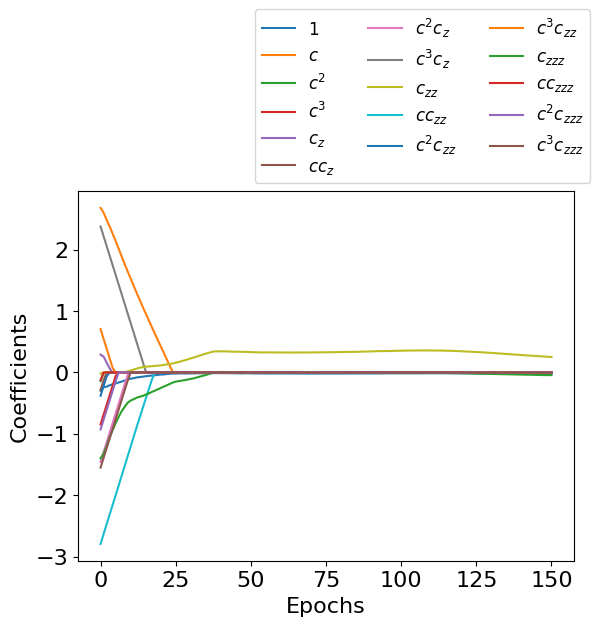

In [ ]:
pinn_sr.plot_coefficient_history()

# Examining the effect of data size

In [ ]:

data_size = [500, 1000, 5000, 10000, 20000, 50000]

for size in data_size:
    print("***************************************************************************")
    print(f"****************   Data size =   {size}     *********************")
    print("***************************************************************************")
    X, T = np.meshgrid(x, t,indexing='ij')
    ## Normalizing the input
    X = X.reshape(-1,1)/(nx-1)
    T = T.reshape(-1,1)/(nt-1)
    c = data.reshape(-1,1)/400
    idx = np.random.choice(X.shape[0], size)
    # idx = np.random.permutation(len(X))[:500]
    X = X[idx]
    T = T[idx]
    c = c[idx]
    pinn_sr = PINN_SR( batch_size=64, num_terms=16)
    pinn_sr.fit(np.hstack((X,T)), c,lr = 0.001, epochs=50,regularizer = 'l1',gamma_1 =1e-5 , alpha_multiplier = 1e-5,gamma_0= 1 )
    pinn_sr.fit(np.hstack((X,T)), c,lr = 0.001, epochs=150,regularizer = 'l0',gamma_1 =1e-5 , alpha_multiplier = 1e-3,gamma_0= 10 )


***************************************************************************
****************   Data size =   500     *********************
***************************************************************************
Epoch: 1; physics-loss 1.5767827033996582; Data Loss: 0.0021948041394352913 Total loss 0.0023343288339674473
c_t =    +-1.518 1 +-0.742 c +-0.646 c^2 +-1.601 c^3 +-0.092 c_z +-0.601 c  c_z +-0.972 c^2 c_z +-1.601 c^3  c_z +-0.704 c_{zz} +0.296 c  c_{zz} +-0.769 c^2 c_{zz} +-0.243 c^3 c_{zz} +-0.214 c_{zzz} +1.679 c c_{zzz} +0.220 c^2 c_{zzz} +0.460 c^3 c_{zzz}
Epoch: 2; physics-loss 1.5402873754501343; Data Loss: 0.0018798692617565393 Total loss 0.0020177499391138554
c_t =    +-1.510 1 +-0.734 c +-0.638 c^2 +-1.594 c^3 +-0.084 c_z +-0.593 c  c_z +-0.964 c^2 c_z +-1.593 c^3  c_z +-0.696 c_{zz} +0.288 c  c_{zz} +-0.761 c^2 c_{zz} +-0.235 c^3 c_{zz} +-0.206 c_{zzz} +1.671 c c_{zzz} +0.212 c^2 c_{zzz} +0.452 c^3 c_{zzz}
Epoch: 3; physics-loss 1.5437262058258057; Data Loss: 0.001

In [ ]:

# alphas = [1e-4, 1e-3]
# for alpha in alphas:
#     pinn_sr.fit(np.hstack((X,T)), c,lr = 0.001, epochs=100, alpha_multiplier = alpha,gamma_1=1e-5 )

In [ ]:
# pinn_sr.torch_module??


## Saving the l1- pretrained model

In [ ]:
# pinn_sr.save_model('./model.pth')
# pinn_sr.load_model('./model.pth')

In [ ]:
# pinn_sr.coefficients

tensor([-1.1465e-02, -4.3552e-04, -1.2920e-04,  1.1394e-04, -6.6550e-04,
        -1.6252e-04, -1.7104e-04,  2.3340e-04,  3.5635e-01, -3.5862e-04,
        -1.4621e-04,  1.2616e-04], device='cuda:0')

In [ ]:
betas = [1e-1]
for j in range(len(betas)):
    pinn_sr.load_model('./model.pth')

    beta = betas[j]
    print("***************************************************************************")
    print(f"****************   Running with Gamma =   {beta}     *********************")
    print("***************************************************************************")
    for i in range(2):
        pinn_sr.fit(np.hstack((X,T)), c,lr = 0.001, epochs=100,regularizer = 'l0',gamma_1 =1e-5 , alpha_multiplier = 1e-3,gamma_0= beta )
    print(f" For beta = {beta}, The coefficients are:", pinn_sr.coefficients.detach().cpu().numpy() )



***************************************************************************
****************   Running with Gamma =   0.1     *********************
***************************************************************************
Epoch: 0; physics-loss 0.037115078419446945; Data Loss: 8.804271055851132e-05 Total loss 0.00012886135664302856
Epoch: 1; physics-loss 0.011233195662498474; Data Loss: 3.117490268778056e-05 Total loss 4.611166150425561e-05
Epoch: 2; physics-loss 0.009483412839472294; Data Loss: 2.9657830964424647e-05 Total loss 4.284480382921174e-05
Epoch: 3; physics-loss 0.01043000165373087; Data Loss: 4.997813084628433e-05 Total loss 6.411169306375086e-05
Epoch: 4; physics-loss 0.009270376525819302; Data Loss: 1.5459567293873988e-05 Total loss 2.8433505576686002e-05
Epoch: 5; physics-loss 0.00834574457257986; Data Loss: 1.6250556654995307e-05 Total loss 2.8299864425207488e-05
Epoch: 6; physics-loss 0.007276939228177071; Data Loss: 0.00010726512846304104 Total loss 0.00011824563262

In [ ]:
def Plot3D(A,title='3D plot',zlim=0,cutBoundary=False):
    shape= np.shape(A)
    cutDist = 50
    nx = shape[0]
    ny = shape[1]
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    y = np.linspace(0,nx-1,nx)
    x = np.linspace(0,(ny-1),ny)
    [X,Y] =np.meshgrid(x,y)
    np.shape(X)


    if cutBoundary ==True:
        surf = ax.plot_surface(X[cutDist:nx-cutDist,4:ny-4], Y[cutDist:nx-cutDist,4:ny-4], A[cutDist:nx-cutDist,4:ny-4], cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    else:
        surf = ax.plot_surface(X, Y, A, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_xlabel(r'Time $t$',rotation=-30)
    ax.set_ylabel(r'Position $x$')
    #ax.set_zlabel('Concentration')
    ax.set_title(title)
    if zlim!=0:
        ax.set_zlim3d(-zlim,zlim)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    plt.savefig(title+'.jpg', dpi = 200)
    return



In [ ]:
x_test = np.linspace(0,nx-1, nx)
t_test = np.linspace(0,nt-1, nt)
X_test, T_test = np.meshgrid(x_test, t_test,indexing='ij')
X_test = X_test.reshape(-1,1)/(nx-1)
T_test = T_test.reshape(-1,1)/(nt-1)
c_pred = pinn_sr.predict(np.hstack((X_test,T_test)))
C_pred  = c_pred.reshape(nx, nt)

In [ ]:
# C_pred.shape
Plot3D(data/(data.max()),'True Data')
Plot3D(C_pred/(C_pred.max()),'Predicted Value')
Plot3D(-data/data.max()+C_pred/(C_pred.max()),'Prediction Error')
